In [12]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.titley': 1.04,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

########## PARAMS ##########
num_runs = 20
diss_rate_target = 0.99
aoi_target = 0.01
v = 28
frame_count = 5

density_low = 4.59598735
density_high = 11.95521146

q_list = [100, 120, 140, 160, 180, 200]
p_list = [100, 90, 80, 70, 60, 50]
i_list = [60, 120, 180, 240, 300, 360, 420]

nn = np.arange(100, 500, 20)

########## UTIL FUNCTIONS ##########

def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

def calculate_confidence_interval(data, confidence=.99):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

def cis_overlap(l_1, h_1, l_2, h_2):
    return (l_1 >= l_2 and l_1 <= h_2) or (h_1 >= l_2 and h_1 <= h_2)

def is_successful_config(diss_rate, excess_probability, config):
    return diss_rate[config] >= diss_rate_target and excess_probability[config] <= aoi_target


def get_best_config(diss_rate, excess_probability, diss_rate_ci):
    meets_reliability_target = len(diss_rate[diss_rate >= diss_rate_target]) > 0
    if meets_reliability_target:
        candidates = diss_rate >= diss_rate_target
        candidates = (1 - excess_probability) * candidates
        return np.unravel_index(np.argmax(candidates), candidates.shape)
    else:
        best = np.unravel_index(np.argmax(diss_rate), diss_rate.shape)
        return best

def get_rdf_config_performance(n,i,q):
    diss_rate = []
    excess_probability = []

    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        return (0, 1, 0 ,0)

    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)


def get_sf_config_performance(n,i,p):
    diss_rate = []
    excess_probability = []
    
    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_sf_n{n}_i{i}_p{p}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        return (0, 1, 0, 0)
        
    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci)


In [13]:
def get_rdf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))

    for x, q in enumerate(q_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_rdf_config_performance(num_nodes, i, q)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)

def get_sf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))

    for x, p in enumerate(p_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci) = get_sf_config_performance(num_nodes, i, p)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci)


def get_rdf_dr():
    data = []
    cis = []
    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci) = get_rdf_performance(n)
        data.append(reliability_target)
        cis.append(reliability_target_ci)

    return (np.array(data), np.array(cis))

def get_rdf_ep():
    data = []
    cis = []
    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci) = get_rdf_performance(n)
        data.append(delay_target)
        cis.append(delay_target_ci)

    return (np.array(data), np.array(cis))


def get_sf_dr():
    data = []
    cis = []
    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci) = get_sf_performance(n)
        data.append(reliability_target)
        cis.append(reliability_target_ci)

    return (np.array(data), np.array(cis))

def get_sf_ep():
    data = []
    cis = []
    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci) = get_sf_performance(n)
        data.append(delay_target)
        cis.append(delay_target_ci)

    return (np.array(data), np.array(cis))


In [14]:
(rdf_dr, rdf_dr_ci) = get_rdf_dr()
(rdf_ep, rdf_ep_ci) = get_rdf_ep()
(sf_dr, sf_dr_ci) = get_sf_dr()
(sf_ep, sf_ep_ci) = get_sf_ep()

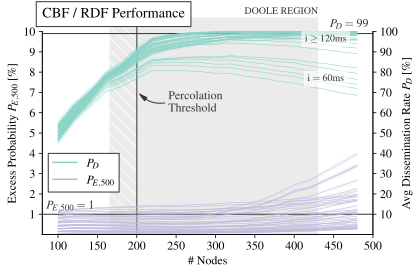

In [15]:
## Plot KPI comparison
ep_max = 10
width = 13

ep_color ='#beb9db'# '#7eb0d5'
dr_color ='#8bd3c7' #'#fd7f6f'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot([80, 500], [1,1], color='#333', lw=1)
ax1.text(85, 1.1, '$P_{E,500} = 1$', ha="left", va="bottom", color="#333", fontsize=12)

ax2.plot([80, 500], [99, 99], color='#333', lw=1)
ax2.text(495, 101, '$P_{D} = 99$', ha="right", va="bottom", color="#333", fontsize=12)

connected_at =1.44 * (6 / 0.509)**2

ax1.fill_between([density_low*36, connected_at], [0,0], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False, hatch='\\\\', ec='#fff', lw=0)
ax1.fill_between([connected_at, density_high* 36], [0,0], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False)
ax1.text(density_high * 36, ep_max * 1.12, "DOOLE REGION",  ha="right", va="top", color='#333', fontsize=10)
ax1.plot([connected_at, connected_at],[0, ep_max * 1.07], color='#333', clip_on=False, lw=1)
ax1.text(connected_at + 40, ep_max * 0.65, "Percolation\nThreshold",  ha="left", va="center", color='#333')
arrow = patches.FancyArrowPatch((connected_at + 38, ep_max * 0.65), (connected_at + 2, ep_max * 0.70), connectionstyle=f"arc3,rad=-0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
ax1.add_patch(arrow)

ax1.set_xlabel('\# Nodes')
ax1.set_ylabel('Excess Probability $P_{E,500}$ [\%]')


## RDF
for x, q in enumerate(q_list):
    for y, i in enumerate(i_list):
        ax1.plot(nn, rdf_ep[:, x, y] * 100, '-', color=ep_color, lw=0.5)
        ax1.fill_between(nn, (rdf_ep[:, x, y] - rdf_ep_ci[:, x, y]) * 100, (rdf_ep[:, x, y] + rdf_ep_ci[:, x, y]) * 100, facecolor=ep_color, interpolate=True, alpha=0.1)

ax1.tick_params(axis='y')
ax1.set_ylim(0, ep_max * 1.0)
ax1.set_xlim(80, 500)
ax1.set_yticks(np.arange(1, ep_max + 1, 1))
ax1.set_yticklabels(range(1, ep_max + 1))

ax2.set_ylabel('Avg Dissemination Rate $P_D$ [\%]')

for x, q in enumerate(q_list):
    for y, i in enumerate(i_list):
        ax2.plot(nn, rdf_dr[:, x, y] * 100, '-', color=dr_color, lw=0.5)
        if x == 2 and y == 0:
            ax2.text(nn[-3], rdf_dr[-3, x, y] * 100, f'i $={i}$ms', color='#333', fontsize=10, ha='center', va='center', bbox=dict(facecolor='#fff', alpha=0.6, ec='#fff', pad=3.0))
        if x == 5 and y == 1:
            ax2.text(nn[-3], rdf_dr[-3, x, y] * 100, f'i $\\geq120$ms', color='#333', fontsize=10, ha='center', va='center', bbox=dict(facecolor='#fff', alpha=0.6, ec='#fff', pad=3.0))
        ax2.fill_between(nn, (rdf_dr[:, x, y] - rdf_dr_ci[:, x, y]) * 100, (rdf_dr[:, x, y] + rdf_dr_ci[:, x, y]) * 100, facecolor=dr_color, interpolate=True, alpha=0.05)

ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)
ax2.set_xlim(80, 500)
ax2.set_yticks(np.arange(10, 110, 10))
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
plt.title('CBF / RDF Performance', loc='left', bbox=dict(pad=6, fc='#fff', ec='#333', lw=1))

plt.plot([-1],[0], '-', label='$P_D$', color=dr_color)
plt.plot([-1],[0], '-',label='$P_{E,500}$', color=ep_color)
leg = plt.legend(fancybox=False, loc="lower left", bbox_to_anchor=(0, 0.18), framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

fig.tight_layout()
fig.savefig(f"../figures/rdf_performance_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"../figures/rdf_performance_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.1)

plt.show()

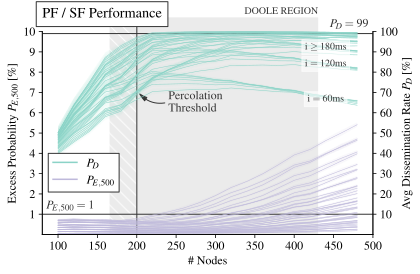

In [16]:
## Plot KPI comparison
ep_max = 10
width = 13

ep_color ='#beb9db'# '#7eb0d5'
dr_color ='#8bd3c7' #'#fd7f6f'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot([80, 500], [1,1], color='#333', lw=1)
ax1.text(85, 1.1, '$P_{E,500} = 1$', ha="left", va="bottom", color="#333", fontsize=12)

ax2.plot([80, 500], [99, 99], color='#333', lw=1)
ax2.text(495, 101, '$P_{D} = 99$', ha="right", va="bottom", color="#333", fontsize=12)

connected_at =1.44 * (6 / 0.509)**2

ax1.fill_between([density_low*36, connected_at], [0,0], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False, hatch='\\\\', ec='#fff', lw=0)
ax1.fill_between([connected_at, density_high* 36], [0,0], [ep_max * 1.07, ep_max * 1.07], facecolor='#ebebeb', interpolate=True, clip_on=False)
ax1.text(density_high * 36, ep_max * 1.12, "DOOLE REGION",  ha="right", va="top", color='#333', fontsize=10)
ax1.plot([connected_at, connected_at],[0, ep_max * 1.07], color='#333', clip_on=False, lw=1)
ax1.text(connected_at + 40, ep_max * 0.65, "Percolation\nThreshold",  ha="left", va="center", color='#333')
arrow = patches.FancyArrowPatch((connected_at + 38, ep_max * 0.65), (connected_at + 2, ep_max * 0.70), connectionstyle=f"arc3,rad=-0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333', zorder=2)
ax1.add_patch(arrow)

ax1.set_xlabel('\# Nodes')
ax1.set_ylabel('Excess Probability $P_{E,500}$ [\%]')


## RDF
for x, p in enumerate(p_list):
    for y, i in enumerate(i_list):
        ax1.plot(nn, sf_ep[:, x, y] * 100, '-', color=ep_color, lw=0.5)
        ax1.fill_between(nn, (sf_ep[:, x, y] - sf_ep_ci[:, x, y]) * 100, (sf_ep[:, x, y] + sf_ep_ci[:, x, y]) * 100, facecolor=ep_color, interpolate=True, alpha=0.1)

ax1.tick_params(axis='y')
ax1.set_ylim(0, ep_max * 1.0)
ax1.set_xlim(80, 500)
ax1.set_yticks(np.arange(1, ep_max + 1, 1))
ax1.set_yticklabels(range(1, ep_max + 1))

ax2.set_ylabel('Avg Dissemination Rate $P_D$ [\%]')

for x, p in enumerate(p_list):
    for y, i in enumerate(i_list):
        ax2.plot(nn, sf_dr[:, x, y] * 100, '-', color=dr_color, lw=0.5)
        if x == 0 and y < 2:
            ax2.text(nn[-3], sf_dr[-3, x, y] * 100, f'i $={i}$ms', color='#333', fontsize=10, ha='center', va='center', bbox=dict(facecolor='#fff', alpha=0.6, ec='#fff', pad=3.0))
        if x == 0 and y == 2:
            ax2.text(nn[-3], sf_dr[-3, x, y] * 100, f'i $\\geq180$ms', color='#333', fontsize=10, ha='center', va='center', bbox=dict(facecolor='#fff', alpha=0.6, ec='#fff', pad=3.0))
        ax2.fill_between(nn, (sf_dr[:, x, y] - sf_dr_ci[:, x, y]) * 100, (sf_dr[:, x, y] + sf_dr_ci[:, x, y]) * 100, facecolor=dr_color, interpolate=True, alpha=0.05)

ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)
ax2.set_xlim(80, 500)
ax2.set_yticks(np.arange(10, 110, 10))
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
plt.title('PF / SF Performance', loc='left', bbox=dict(pad=6, fc='#fff', ec='#333', lw=1))
plt.plot([-1],[0], '-', label='$P_D$', color=dr_color)
plt.plot([-1],[0], '-',label='$P_{E,500}$', color=ep_color)
leg = plt.legend(fancybox=False, loc="lower left", bbox_to_anchor=(0, 0.18), framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

fig.tight_layout()
fig.savefig(f"../figures/sf_performance_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"../figures/sf_performance_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.1)

plt.show()